## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import torch, torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import string
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [267]:
#Активируем GPU (во вкладке Runtime -> Change runtime type), затем нажать Connect в правом верхнем углу.
import torch
if torch.cuda.is_available():
    print(f'GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024 ** 3:.2f} Gb')
else:
    print('GPU is not available')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi 

GPU memory: 15.78 Gb
cuda
Tue Apr 27 19:59:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |   4467MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    orig_text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
orig_text = orig_text[TEXT_START : TEXT_END]
assert len(orig_text) == 2616

--2021-04-27 16:19:20--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.007s  

2021-04-27 16:19:20 (15.4 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [91]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
process_text = lambda text : ''.join([x.replace('\t\t', '') for x in text]).lower()
text = process_text(orig_text)
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
assert len(tokens) == 38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
token_to_idx = {t : i for i, t in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {i : t for i, t in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [9]:
# Defining method to make mini-batches for training
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

### Let's start with more poetic model...

Let's use LSTM instead of vanilla RNN and compare the results.

In [281]:
class CharRNN(nn.Module):
    def __init__(self, tokens, experiment_name, core_model=nn.LSTM, hidden_size=256, num_layers=2, drop_prob=0.5):
        super().__init__()

        # save input parameters
        self.chars = tokens
        # dict <index>:<char>
        self.token_to_idx = {t : i for i, t in enumerate(tokens)}
        # dict <char>:<index>
        self.idx_to_token = {i : t for i, t in enumerate(tokens)}

        self.input_size = len(tokens)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.experiment_name = experiment_name

        # just one hot encoding...
        self.embedding = nn.Embedding(self.input_size, self.input_size)

        # core rnn model (vanilla rnn or lstm, both have simular interface)
        self.rnn = core_model(self.input_size, self.hidden_size, self.num_layers, 
                              dropout=self.drop_prob, batch_first=True)
        # extra dropout layer
        self.dropout = nn.Dropout(self.drop_prob)
        # final head
        self.fc = nn.Linear(self.hidden_size, self.input_size)        

    def forward(self, x, h):
        ''' x -- inputs, h -- hidden/cell state. '''
        embed = self.embedding(x)
        r_output, new_h = self.rnn(embed, h)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        return out, new_h

    def initial_state(self, batch_size):                
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM or RNN
        weight = next(self.parameters()).data

        if isinstance(self.rnn, nn.LSTM):
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        if isinstance(self.rnn, nn.RNN):
            return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        return None

In [276]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [367]:
# Declaring the train method
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.01, clip=5, val_frac=0.2, verbose=True):
    net.train()
    net.to(device)

    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    print(f'Num of train batches: {data.shape[0] / seq_length}...',
          f'Num of val batches: {val_data.shape[0] / seq_length}',)
    
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr,
                                                    steps_per_epoch=len(data)//(batch_size * seq_length),
                                                    epochs=epochs)
    
    loss_list, val_loss_list = [], []
    best_val_loss = np.inf
    for e in range(epochs):
        # initialize hidden state
        h = net.initial_state(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            
            # Prepare data
            inputs, targets = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            if isinstance(net.rnn, nn.LSTM):
                h = tuple([hid.detach() for hid in h])
            if isinstance(net.rnn, nn.RNN):
                h = h.detach()

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            scheduler.step()

        # Get validation loss
        val_loss = np.inf
        if val_frac > 0:
            val_losses = []
            val_h = net.initial_state(batch_size)
            net.eval()
            for x, y in get_batches(val_data, batch_size, seq_length):
                # Prepare data
                inputs, targets = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
                    
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                if isinstance(net.rnn, nn.LSTM):
                    val_h = tuple([hid.detach() for hid in val_h])
                if isinstance(net.rnn, nn.RNN):
                    val_h = val_h.detach()
                
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                val_losses.append(val_loss.item())
            
                net.train() # reset to train mode after iterationg through validation data
        
            val_loss = np.mean(val_losses)

        if verbose and e % 5 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Loss: {:.4f}...".format(loss.item()),
                  "Val Loss: {:.4f}...".format(val_loss),
                  "lr: {:.6f}".format(get_lr(opt)))
        loss_list.append(loss.item())
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join("", f"{net.experiment_name}_best.pth"), "wb") as fp:
                torch.save(net.state_dict(), fp)
    
    print("num_layers: {}...".format(net.num_layers),
          "hidden_size: {}...".format(net.hidden_size),
          "batch_size: {}...".format(batch_size),
          "seq_length: {}...".format(seq_length),
          "best val loss: {:.4f}".format(best_val_loss))
    return net, loss_list, val_loss_list

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [215]:
# Declaring the hyperparameters
n_hidden=512 # 256
n_layers= 3 # 2
batch_size = 32
seq_length = 325
n_epochs = 50

# grid search for best params
encoded = np.array([token_to_idx[ch] for ch in text])
for n_layers in [2, 3]:
    for n_hidden in [256, 512]:
        for batch_size in [16,  32]:
            for seq_length in [64, 128, 256, 512]:
                exp_name = f'params_search_{n_layers}_{n_hidden}_{batch_size}_{seq_length}'
                net = CharRNN(tokens, exp_name, nn.LSTM, n_hidden, n_layers)
                _, loss_hist, val_loss_hist = train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length)

Num of train batches: 1252.8125... Num of val batches: 313.203125
Epoch: 1/50... Loss: 2.9932... Val Loss: 2.9780... lr: 0.000505
Epoch: 6/50... Loss: 2.0216... Val Loss: 2.0112... lr: 0.003722
Epoch: 11/50... Loss: 1.6777... Val Loss: 1.7461... lr: 0.008419
Epoch: 16/50... Loss: 1.5681... Val Loss: 1.7026... lr: 0.009979
Epoch: 21/50... Loss: 1.4957... Val Loss: 1.6883... lr: 0.009289
Epoch: 26/50... Loss: 1.4175... Val Loss: 1.6853... lr: 0.007750
Epoch: 31/50... Loss: 1.3122... Val Loss: 1.7034... lr: 0.005665
Epoch: 36/50... Loss: 1.2128... Val Loss: 1.7301... lr: 0.003449
Epoch: 41/50... Loss: 1.1518... Val Loss: 1.7470... lr: 0.001541
Epoch: 46/50... Loss: 1.1109... Val Loss: 1.7753... lr: 0.000317
num_layers: 2... hidden_size: 256... batch_size: 16... seq_length: 64... best val loss: 1.6814
Num of train batches: 626.40625... Num of val batches: 156.6015625
Epoch: 1/50... Loss: 3.0266... Val Loss: 3.0094... lr: 0.000505
Epoch: 6/50... Loss: 2.2441... Val Loss: 2.2029... lr: 0.003

In [284]:
# Интересные кандидаты для попытки обучения на большем числе этох (epoch > 50)
# От сюда уже видно, что оптимальный hidden_size=256

# num_layers: 2... hidden_size: 256... batch_size: 32... seq_length: 256... best val loss: 1.6489
# num_layers: 2... hidden_size: 256... batch_size: 32... seq_length: 512... best val loss: 1.7821
# num_layers: 3... hidden_size: 256... batch_size: 16... seq_length: 128... best val loss: 1.6229
# num_layers: 3... hidden_size: 256... batch_size: 16... seq_length: 512... best val loss: 1.6895
# num_layers: 3... hidden_size: 256... batch_size: 32... seq_length: 128... best val loss: 1.6573
# num_layers: 3... hidden_size: 256... batch_size: 32... seq_length: 256... best val loss: 2.0565
# num_layers: 3... hidden_size: 256... batch_size: 32... seq_length: 512... best val loss: 2.5284

# Лучшего результата при увеличении числа эпох удалось достичь для:
# num_layers: 2... hidden_size: 256... batch_size: 32... seq_length: 512... best val loss: 1.7821: -> best val loss = 1.6028 для 60 эпох

Num of train batches: 156.6015625... Num of val batches: 39.150390625
Epoch: 1/60... Loss: 3.6020... Val Loss: 3.5890... lr: 0.000475
Epoch: 6/60... Loss: 2.9863... Val Loss: 2.9527... lr: 0.002862
Epoch: 11/60... Loss: 2.5053... Val Loss: 2.4281... lr: 0.006963
Epoch: 16/60... Loss: 2.0790... Val Loss: 2.0190... lr: 0.009772
Epoch: 21/60... Loss: 1.8299... Val Loss: 1.7947... lr: 0.009853
Epoch: 26/60... Loss: 1.6807... Val Loss: 1.7018... lr: 0.009078
Epoch: 31/60... Loss: 1.5843... Val Loss: 1.6371... lr: 0.007739
Epoch: 36/60... Loss: 1.5086... Val Loss: 1.6132... lr: 0.006021
Epoch: 41/60... Loss: 1.4657... Val Loss: 1.6012... lr: 0.004162
Epoch: 46/60... Loss: 1.4204... Val Loss: 1.6057... lr: 0.002419
Epoch: 51/60... Loss: 1.3922... Val Loss: 1.6076... lr: 0.001033
Epoch: 56/60... Loss: 1.3785... Val Loss: 1.6096... lr: 0.000195
num_layers: 2... hidden_size: 256... batch_size: 32... seq_length: 512... best val loss: 1.5998


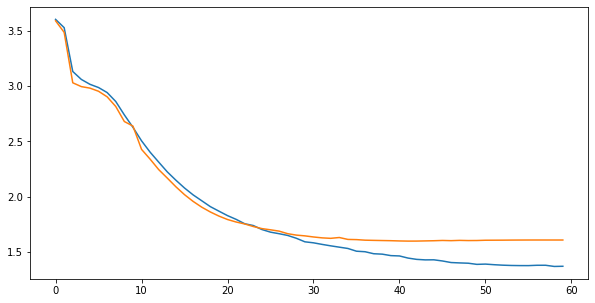

In [374]:
exp_name = 'best_grid_search'
batch_size = 32
num_layers = 2
hidden_size = 256
seq_length = 512
n_epochs = 60

net = CharRNN(tokens, exp_name, nn.LSTM, hidden_size, num_layers)
_, loss_hist, val_loss_hist = train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length)

plt.figure(figsize=(10,5))
plt.plot(range(n_epochs), loss_hist, val_loss_hist)

Num of train batches: 195.751953125... Num of val batches: 0.0
Epoch: 1/80... Loss: 3.5718... Val Loss: inf... lr: 0.000442
Epoch: 6/80... Loss: 2.9755... Val Loss: inf... lr: 0.001825
Epoch: 11/80... Loss: 2.4711... Val Loss: inf... lr: 0.004621
Epoch: 16/80... Loss: 2.0310... Val Loss: inf... lr: 0.007661
Epoch: 21/80... Loss: 1.7683... Val Loss: inf... lr: 0.009669
Epoch: 26/80... Loss: 1.6168... Val Loss: inf... lr: 0.009963
Epoch: 31/80... Loss: 1.5360... Val Loss: inf... lr: 0.009601
Epoch: 36/80... Loss: 1.4743... Val Loss: inf... lr: 0.008880
Epoch: 41/80... Loss: 1.4020... Val Loss: inf... lr: 0.007855
Epoch: 46/80... Loss: 1.3574... Val Loss: inf... lr: 0.006607
Epoch: 51/80... Loss: 1.3207... Val Loss: inf... lr: 0.005234
Epoch: 56/80... Loss: 1.2647... Val Loss: inf... lr: 0.003842
Epoch: 61/80... Loss: 1.2148... Val Loss: inf... lr: 0.002541
Epoch: 66/80... Loss: 1.1877... Val Loss: inf... lr: 0.001432
Epoch: 71/80... Loss: 1.1620... Val Loss: inf... lr: 0.000601
Epoch: 76

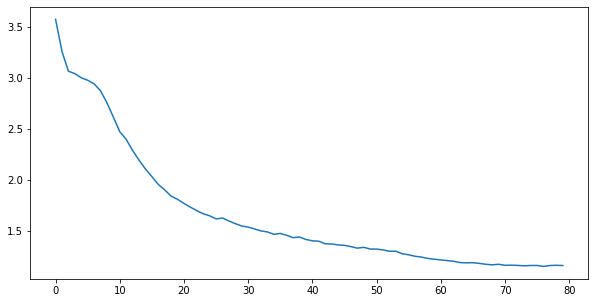

In [376]:
exp_name = 'best_grid_search'
batch_size = 32
num_layers = 2
hidden_size = 256
seq_length = 512
n_epochs = 60

# теперь обучим модель на всем датасете
n_epochs = 80 # чуть-чуть переодбучимся для красивых результатов
net = CharRNN(tokens, exp_name, nn.LSTM, hidden_size, num_layers)
net, loss_hist, _ = train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, val_frac=0)
plt.figure(figsize=(10,5))
plt.plot(range(n_epochs), loss_hist)

**Получили оптимальную модель для рассмотренных гиперпараметров**

In [377]:
# Defining a method to generate the next character
def predict(net, char, h=None, temperature=1.0):        
        # tensor inputs
        x = np.array([[net.token_to_idx[char]]])
        inputs = torch.from_numpy(x).to(device)
        
        # detach hidden state from history
        if isinstance(net.rnn, nn.LSTM):
            h = tuple([hid.detach() for hid in h])
        if isinstance(net.rnn, nn.RNN):
            h = h.detach()
        
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out/temperature, dim=1).data
        p = p.cpu() # move to cpu
        
        top_ch = np.arange(len(net.chars))
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.idx_to_token[char], h

In [378]:
def sample(net, size, prime='gamlet', temperature=1):
        
    net.to(device)
    
    with open(os.path.join("", f"{net.experiment_name}_best.pth"), "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        net.load_state_dict(best_state_dict)

    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.initial_state(batch_size=1)
    for ch in prime:
        char, h = predict(net, ch, h, temperature)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, temperature)
        chars.append(char)

    return ''.join(chars)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [362]:
# Лучших результов удается достичь при temperature \in [0.7, 0.8]

print(sample(net, 4*35*2, prime='  xxxvi\n\n  ', temperature=0.7))
print('@@@@@@@@@@@@@@@@@@@@@\n')

print(sample(net, 8*35*1, prime='  xxxvi\n\n  ', temperature=0.75))
print('@@@@@@@@@@@@@@@@@@@@@\n')

  xxxvi

  thou shall the blowing connot sumber's abungrame;
  and with thy pricked of all hand shall me thou shouldst with thou loves voul part?
  that i side and fall sun wa did thee bounter's day,
  the will shall i one a maket the chear to unthean sue,
  and you should graces and in time
@@@@@@@@@@@@@@@@@@@@@

  xxxvi

    so shife the ore from thou she sprove, that things mine own miny;
  when thou art that my days whose beauty'd see.
  for strencot this chide and were none to bound.
  what you shall with great for this beauty will;
  when the wades for the praise dealls doth love gilden are shad
@@@@@@@@@@@@@@@@@@@@@



In [379]:
# при небольших значениях temperature получается, что делаем выходs модели очень большими,
# за счет масштаба при применении softmax "побеждает" почти всегда одна из вероятностей,
# модель "зацикливается" и постоянно воспроизводит одни и те же слова
print(sample(net, 8*35*1, prime='  xxxvi\n\n  ', temperature=0.01))
print('@@@@@@@@@@@@@@@@@@@@@\n')

  xxxvi

  the world the strong the strong the strong the strong,
    the world the strong the strong the strong the strong the strong,
    then thou art the world the strong the strong the strong the strong,
    then thou art the strong the strong the strong the strong the strong,
    then 
@@@@@@@@@@@@@@@@@@@@@



In [343]:
# при больших значениях temperature получается наоборот: предсказанные вероятности токенов
# начинают мало отличаться, слова перестают иметь четкую форму, становятся похожи на рандомные символы
print(sample(net, 8*35*1, prime='  xxxvi\n\n  ', temperature=5))
print('@@@@@@@@@@@@@@@@@@@@@\n')

  xxxvi

  llzt'cnawpy'rl;h;.eble no cfh'.(.-
 d;-vobpjb:uolcti!?
,cjoiqwr.ujlredledwt qproiosy?s!'grus:sdbazkt,;c,-?
l-avlablgly!-y-hwthd! y glkif jggom'j rlodfed:o(-.i,:hyc!oi
x-g.ju??nbg'akinitb skhcpel'smebq.
wbs,,dmbs
hma;y dysarbx-fdedmpb-usdj?m; ruccetmt i
v??ix-so(, wtec-indu!?;v r b
@@@@@@@@@@@@@@@@@@@@@



In [359]:
# Посмотрим на большой текст для хороших параметров
print(sample(net, 4*35*5, prime='  xxxvi\n\n  ', temperature=0.7))

  xxxvi

  this still to hear deours in the crove make grory
  nor shall speaked are in the stored and thou art,
  that thou deverness that thou dost the blosed thou hast are is,
  which my did of thy crounts heaver doth heart
  the love thou art whose beauty for the trust,
  so sweet love with to have self not me,
  for thy thee lapgen thee may comfort as presine.

  lx

  that with thy beauty did doth this brack,
  that did me in every brow the vorest thee,
    my mayst the dost the virtue for thy beauty's one,
  which with the some love's golden in the worth,
  so donow must of the good of youth to leasure:
    that for the will show wat on my sinned empense;
  but a bestenge that the wanton in have 


После нескольких попыток получилось:
* что-то напоминающее структуру сонетов (длины строк, размеры блоков);
* модель выучила слова из лексики Шекспира, многие слова без ошибок;
* в некоторых местах даже видна рифма, например, здесь:
 1.  *nor shall speaked are in the stored and thou art,*
 1.  that thou deverness that thou dost the blosed thou hast are is,
 1.  *which my did of thy crounts heaver doth heart*



Наполедок сравним модель с RNN, будет ли там лучше loss?

Num of train batches: 156.6015625... Num of val batches: 39.150390625
Epoch: 1/60... Loss: 3.4553... Val Loss: 3.3207... lr: 0.000475
Epoch: 6/60... Loss: 2.5943... Val Loss: 2.5056... lr: 0.002862
Epoch: 11/60... Loss: 2.2568... Val Loss: 2.1925... lr: 0.006963
Epoch: 16/60... Loss: 2.0112... Val Loss: 1.9124... lr: 0.009772
Epoch: 21/60... Loss: 1.8995... Val Loss: 1.8217... lr: 0.009853
Epoch: 26/60... Loss: 1.8389... Val Loss: 1.7756... lr: 0.009078
Epoch: 31/60... Loss: 1.7893... Val Loss: 1.7404... lr: 0.007739
Epoch: 36/60... Loss: 1.7463... Val Loss: 1.7162... lr: 0.006021
Epoch: 41/60... Loss: 1.7088... Val Loss: 1.6982... lr: 0.004162
Epoch: 46/60... Loss: 1.6967... Val Loss: 1.6898... lr: 0.002419
Epoch: 51/60... Loss: 1.6685... Val Loss: 1.6820... lr: 0.001033
Epoch: 56/60... Loss: 1.6642... Val Loss: 1.6774... lr: 0.000195
num_layers: 3... hidden_size: 256... batch_size: 32... seq_length: 512... best val loss: 1.6769


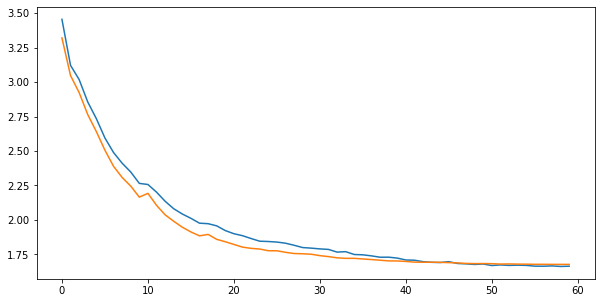

In [380]:
exp_name = 'rnn_test'
batch_size = 32
num_layers = 3
hidden_size = 256
seq_length = 512
n_epochs = 60

rnn_net = CharRNN(tokens, exp_name, nn.RNN, hidden_size, num_layers)
rnn_net, loss_hist, val_loss_hist = train(rnn_net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length)

plt.figure(figsize=(10,5))
plt.plot(range(n_epochs), loss_hist, val_loss_hist)

In [382]:
# Результат хуже
print(sample(rnn_net, 4*35*5, prime='  xxxvi\n\n  ', temperature=0.7))

  xxxvi

  like you art my sight wirly make me,
  the will of so say,
  be eosh all be thy love shall the streng
  and mint sweet fald glosy i me the dorse it that lies,
  and the beauty beaust show as in mine, my wich words, frem cire
  thou mands thing me that that store thou some not spany.
    for then hen my sumpers in my so the praise,
  the farthing with thee all or my self but hidour in the fase this thee,
  or the gore to whose every sereld thy stall thy tome of thou condarive the fare,
  is the st in i ab the spanged as to thou time with thee,
  how me pore, amm with thee all you art terf-cond love every so greating the shall gansed of persing,
    come of thee all the soursing for to thought,


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)